### Some Sources:
1. Source of Sources: https://guides.lib.umich.edu/c.php?g=637508&p=4462444
2. All Sides: https://www.allsides.com/unbiased-balanced-news
3. Facebooks Side by Side: http://graphics.wsj.com/blue-feed-red-feed/
4. Center:
    - WSJ
    - USA Today
    - BBC News
5. Left (from more centered to far left):
    - NPR
    - NYT
    - Washington Post
    - CNN
    - Huffington Post
    - Mother Jones
6. Right (from more centered to far right):
    - Fox News
    - The Glaze/Beck Program
    - Drudge Report
    
    
## IDEAS:
1. Classify as either left, central or right
2. Classify as coming from CNN or Fox
3. Include a word map
4. Given today's news, give the user a report of which companies/individuals were mentioned (Named Entity Recognition)


In [98]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd
from urllib.request import urlopen
import numpy as np
from datetime import datetime
import os

# Text Processing
import nltk
from keras import preprocessing
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
from nltk.text import Text  

# Visualizatoin
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

# Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict
from keras.layers import LSTM, Embedding, Dense
from keras.models import Sequential

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from flask import Flask, request

In [99]:
# Function to get articles headline and organize into dataframe

'''TODO: Add button capability so it can get more than just the first five news of each 
inclination under titles'''

def get_allsides_titles():
    '''Parses through left, center and right-inclined headlines
    Source: www.allsides.com
    Returns a dataframe with headings classified as left, center, right
    '''
    # Provide URLs
    main_url = 'https://www.allsides.com/unbiased-balanced-news'
    
    topics_list = ['bridging-divides', 'criminal-justice', 'election-2012', 'environment',
                  'healthcare', 'gay-rights', 'nuclear-weapons', 'taxes', 'campaign-finance', 'economy-jobs',
                  'elections', 'free-speech', 'immigration', 'media-bias-media-watch', 'polarization', 'terrorism', 
                  'civil-rights', 'education', 'energy', 'guns', 'inequality', 
                  'middle-east', 'role-government', 'trade']
    url_list = ["https://www.allsides.com/topics/{}".format(topic) for topic in topics_list]
    url_list.append(main_url)
    
    # Create main data frame where all headlines will be added
    df = pd.DataFrame(columns=['Headlines', 'Source', 'Inclination']) 
    
    # Loop through URLs to get news titles
    for url in url_list:
#         print('Getting Data From: {}'.format(url))
        html = urlopen(url)

        # Read all html data
        soup = BeautifulSoup(html.read(), 'lxml')

        # Get headlines and add to dataframe
        for side in ['left', 'right', 'center']:
            section = soup.find(class_='region-triptych-{}'.format(side))
            title_links = section.find_all(class_='news-title')
            source_links = section.find_all(class_='news-source')
            titles = [i.get_text()[1:-1] for i in title_links]
            sources = [i.get_text() for i in source_links]

            df_side = pd.DataFrame({'Headlines': titles, 
                                    'Inclination': [side]*len(titles),
                                    'Source': sources})

            df = pd.concat([df, df_side], axis=0, sort=True)

    df.reset_index(drop=True, inplace=True)
    df.drop_duplicates(inplace=True)

    return(df)

In [100]:
# Get Headlines
allsides_df = get_allsides_titles()
display(allsides_df.head())

,Headlines,Inclination,Source
0,Intellectual humility: the importance of knowi...,left,Vox
1,The Bipartisan Group That’s Not Afraid of Part...,left,The Atlantic
2,Bill Clinton: George H.W. Bush’s Oval Office n...,left,Washington Post
3,Can lefties and right-wingers find common grou...,left,San Francisco Chronicle
4,Train for Thanksgiving With Our Angry Uncle Bot,left,Guest Writer - Left


In [101]:
# Save Today's DataFrame
date = datetime.today().strftime('%Y-%m-%d')
this_dir = os.path.dirname(os.path.abspath("__file__"))
dump_dir = os.path.join(this_dir, "Extracted Data")
file_path = os.path.join(dump_dir, "allsides_{}{}".format(date,".csv"))
allsides_df.to_csv(file_path)

## ---------

In [102]:
headlines_df = pd.DataFrame()

for fname in os.listdir(dump_dir):
    file_path = os.path.join(dump_dir, fname)
    df = pd.read_csv(file_path, encoding="utf8")
    headlines_df = pd.concat([headlines_df, df], axis=0, sort=True)

headlines_df.drop("Unnamed: 0", inplace=True, axis=1)
display(headlines_df.head())
print(headlines_df.shape)

# Remove Duplicates
headlines_df.drop_duplicates(inplace=True)
print(headlines_df.shape)

,Headlines,Inclination,Source
0,"Trumpy Bear: the perfect Christmas gift, no ma...",left,NaN
1,Russian 2016 Influence Operation Targeted Afri...,left,NaN
2,Russia’s Pro-Trump Disinformation Campaign Use...,left,NaN
3,The Republican Party versus democracy,left,NaN
4,OPINION: Trump slams Russia probe in face of n...,left,NaN


(5178, 3)
(879, 3)


Proportion of News Sources Inclination


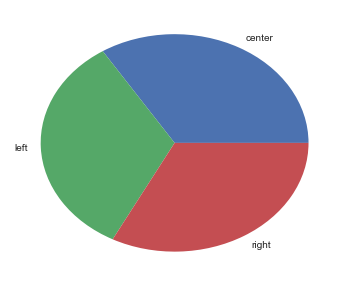

In [103]:
print("Proportion of News Sources Inclination")
plt.figure(figsize=(6, 5))
_ = plt.pie(headlines_df['Inclination'].value_counts(), labels=np.unique(headlines_df['Inclination']),
           )

In [104]:
# Shuffle Headlines
shuffled_headlines_df = headlines_df.sample(len(headlines_df))
shuffled_headlines_df.head(10)

,Headlines,Inclination,Source
391,Negotiations Stall as Government Shutdown Pois...,center,AllSides
359,Covington Catholic Students Claim Death Threat...,left,Daily Beast
181,What’s actually happening at the US-Mexico bor...,left,Vox
363,Trump administration lays groundwork to declar...,left,Washington Post
352,Trump's War on Trade,right,Reason
300,Mitt Romney’s statement on the Charlottesville...,left,Vox
171,Jordan B. Peterson's free speech fight: Author...,right,Washington Times
186,"Shutdown Theater, Again",right,National Review
43,New Podcast: The Media Outlets with the Most S...,center,NaN
172,Twitter Permanently Banned Conservative Pundit...,right,Reason


In [105]:
# # Define function to process text
def text_process(mess):# mess stands for message
    '''
    1. Remove punctuation
    2. Remove Stop Words
    3. Return list of cleaned text words
    '''
    nopunc = [c for c in mess if c not in string.punctuation]
    nopunc = "".join(nopunc) # to join together separated characters back into words
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(w) for w in nopunc.split() if w.lower() not in stopwords.words('english')] # returns a list of list of words
    cleaned_sent = " ".join(lemmatized_words) # returns a list of sentences
    return(cleaned_sent)

# Process Text
clean_headlines = [text_process(mess) for mess in shuffled_headlines_df['Headlines']]
print(clean_headlines[:3])

['Negotiations Stall Government Shutdown Poised Become Longest History', 'Covington Catholic Students Claim Death Threats DC Encounter', 'What’s actually happening USMexico border explained']


In [106]:
# Convert Inclinations to Categories and Define y as numerical labels
shuffled_headlines_df['Inclination'] = pd.Categorical(shuffled_headlines_df['Inclination'])
y = shuffled_headlines_df['Inclination'].cat.codes
labels_dict = dict(enumerate(shuffled_headlines_df['Inclination'].cat.categories))
print(labels_dict)

{0: 'center', 1: 'left', 2: 'right'}


In [107]:
# Split into Train and Test
headlines_train, headlines_test, y_train, y_test = train_test_split(clean_headlines, y, test_size=0.25)

In [133]:
my_headline = "todos vamos a morir"
if len(my_headline) < 15 or len(my_headline) > 75:
    print("Error")

In [108]:
# Define Function to Get TF-IDF Scores and Counts

def get_word_scores(train_data, test_data, vectorizer): 
    ''' Function to vectorize data and get words scores. In this particular case
    we are using it for tf-idf scores and word counts. 
    The reason to include the test data, which is not immediately apparent, is that one of the classifiers in our
    sentiment analysis will be based off the tf-idf and count vectors.
    Input: training list of sentences, test list of sentences, and the vectorizer to use (e.g. CountVectorizer)
    Outpout: train and test observations in tf-idf scores form, word score, and the fitted vectorizer '''
    
    # Fit vectorizer to train data. Transform train and test sets
    vectorizer.fit(train_data)
    x_train =  vectorizer.transform(train_data) 
    x_test = vectorizer.transform(test_data)

    # Highest TF-IDF Scores
    vocab = vectorizer.vocabulary_ # gives the number of words in our vocabulary
    sum_words = x_train.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in vocab.items()], 
                        key=lambda x: x[1], reverse=True)
    return(x_train, x_test, words_freq, vectorizer)


# Get TF-IDF Score Vectors on Headliens
tf_vectorizer = TfidfVectorizer(min_df=3, max_features=1000, strip_accents='unicode', analyzer='word',
            ngram_range=(1, 1), use_idf=1, smooth_idf=1, sublinear_tf=1, stop_words='english')

X_train_tf, X_test_tf, tf_scores, tf_model = get_word_scores(headlines_train, headlines_test, tf_vectorizer)

# Get Counts Vectors on Headlines
count_vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words='english', max_features=1000)

X_train_ct, X_test_ct, words_count, count_model = get_word_scores(headlines_train, headlines_test, count_vectorizer)

In [123]:
my_str = 'estabamos jugando todos'
my_str.upper()

'ESTABAMOS JUGANDO TODOS'

In [109]:
# Set Up Training Features
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(multi_class='ovr'),
]

CV = 10

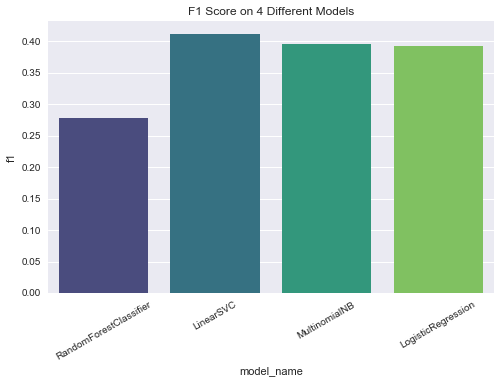

In [110]:
##### TF-IDF SCORES ####

# Set parameters for cross validation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# Fit models
for model in models:
    model_name = model.__class__.__name__
    y_pred = cross_val_predict(model, X_train_tf, y_train, cv=10)
    f1 = f1_score(y_train, y_pred, average='macro')
    entries.append((model_name, f1))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'f1'])
   
# Plot F1 scores
fig, axes = plt.subplots(figsize=(8, 5))
sns.barplot(x='model_name', y='f1', data=cv_df, palette='viridis')
axes.set_xticklabels(rotation=30, labels=cv_df['model_name'])
axes.set(title="F1 Score on 4 Different Models")
plt.show()

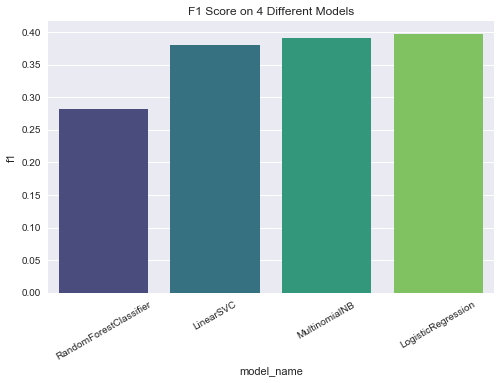

In [111]:
##### COUNT VECTOR SCORES ####

# Set parameters for cross validation
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

# Fit models
for model in models:
    model_name = model.__class__.__name__
    y_pred = cross_val_predict(model, X_train_ct, y_train, cv=10)
    f1 = f1_score(y_train, y_pred, average='macro')
    entries.append((model_name, f1))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'f1'])
   
# Plot F1 scores
fig, axes = plt.subplots(figsize=(8, 5))
sns.barplot(x='model_name', y='f1', data=cv_df, palette='viridis')
axes.set_xticklabels(rotation=30, labels=cv_df['model_name'])
axes.set(title="F1 Score on 4 Different Models")
plt.show()

In [113]:
# Get Report on Best Performing Model So far

log_reg_model = LogisticRegression(multi_class='ovr')
log_reg_model.fit(X_train_tf, y_train)
pred_log_reg = log_reg_model.predict(X_test_tf)

# Reports
print('Classification Report: ', '\n', classification_report(y_test, pred_log_reg))
print(confusion_matrix(y_test, pred_log_reg))

Classification Report:  
              precision    recall  f1-score   support

          0       0.51      0.42      0.46        84
          1       0.36      0.38      0.37        66
          2       0.48      0.56      0.51        70

avg / total       0.45      0.45      0.45       220

[[35 29 20]
 [18 25 23]
 [15 16 39]]


In [114]:
##### RNN #####

# Define Headlines Vector Parameters
max_words = 1000
max_len = 20
max_features = 100


# Tokenize and Pad
def tokenize_and_pad(train_array, test_array, max_words):

    '''Takes the training and testing dataframes, as well as the desired vocab size as input and returns:
    1. tokenized, padded train comments
    2. tokenized, padded test comments
    3. train labels
    4. test labels
    5. the word_index to associate numerical vectors to sentences'''
    
    tokenizer = Tokenizer(num_words=max_words) 
    tokenizer.fit_on_texts(train_array) # creates a list of tokens (words) of the 10000 most common words on "texts"
    train_tokens = tokenizer.texts_to_sequences(train_array) # converts "texts" into sequences of tokens for the 10000 most common words
    test_tokens = tokenizer.texts_to_sequences(test_array)

    word_index = tokenizer.word_index
    train_padded = pad_sequences(train_tokens, maxlen=max_len)
    test_padded = pad_sequences(test_tokens, maxlen=max_len)

    return(train_padded, test_padded, word_index)


# Get sentence vectors and labels
token_headlines_train, token_headlines_test, word_index = tokenize_and_pad(headlines_train, headlines_test, max_words)

# Convert y to one-hot encoding
y_train_oh = pd.get_dummies(y_train)
y_test_oh = pd.get_dummies(y_test)

# Load Embeddings File
glove_dir = r'C:\Users\dbejarano\Dropbox\Data Analytics Projects\03 Pre-Trained Basis'
glove_file_path = os.path.join(glove_dir, 'glove.6B.100d.txt')


# Create Embedding Matrix
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embed_size = 100
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(glove_file_path, encoding="utf8"))

nb_words = min(max_words, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i-1] = embedding_vector

In [115]:
# Build Model
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embed_size, weights=[embedding_matrix]))
rnn_model.add(LSTM(32))
rnn_model.add(Dense(3, activation='softmax'))

# Train Model
rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
rnn_history = rnn_model.fit(token_headlines_train, y_train_oh, epochs=10, batch_size=32, validation_split=0.2)

Train on 527 samples, validate on 132 samples
Epoch 1/10
527/527 [==============================] - 2s 5ms/step - loss: 1.1114 - acc: 0.3605 - val_loss: 1.1182 - val_acc: 0.3333
Epoch 2/10
527/527 [==============================] - 0s 774us/step - loss: 1.0664 - acc: 0.4194 - val_loss: 1.1483 - val_acc: 0.2879
Epoch 3/10
527/527 [==============================] - 0s 700us/step - loss: 1.0411 - acc: 0.4535 - val_loss: 1.1141 - val_acc: 0.3788
Epoch 4/10
527/527 [==============================] - 0s 693us/step - loss: 1.0115 - acc: 0.5218 - val_loss: 1.1200 - val_acc: 0.3636
Epoch 5/10
527/527 [==============================] - 0s 704us/step - loss: 0.9743 - acc: 0.5674 - val_loss: 1.1107 - val_acc: 0.3712
Epoch 6/10
527/527 [==============================] - 0s 679us/step - loss: 0.9311 - acc: 0.5977 - val_loss: 1.1046 - val_acc: 0.3636
Epoch 7/10
527/527 [==============================] - 0s 704us/step - loss: 0.8815 - acc: 0.6546 - val_loss: 1.1264 - val_acc: 0.3939
Epoch 8/10
527/527

220/220 [==============================] - 0s 2ms/step


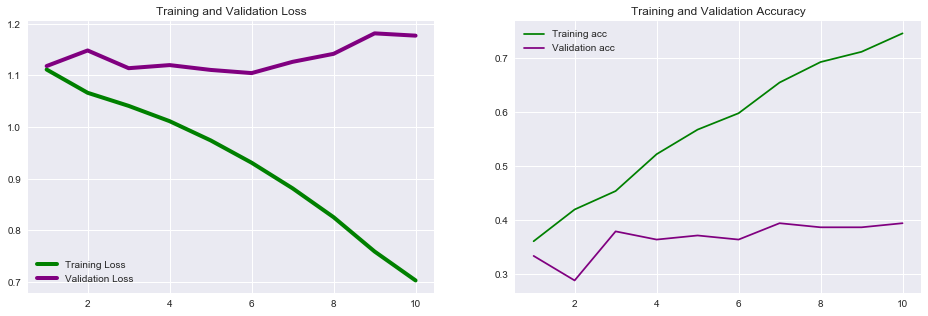

In [116]:
# Predict and Evaluate
pred_rnn = rnn_model.predict(token_headlines_test, verbose=1)

# Plot Training and Validation Losses and Accuracy Per Epoch
epochs = range(1, len(rnn_history.history['loss'])+1)
fig, axes = plt.subplots(nrows=1, ncols=2, )
fig.set_size_inches(16, 5)
axes[0].plot(epochs, rnn_history.history['loss'], color='green', label='Training Loss', linewidth=4)
axes[0].plot(epochs, rnn_history.history['val_loss'], color='purple', label='Validation Loss', linewidth=4)
axes[0].set(title='Training and Validation Loss')
axes[0].legend()
mpl.style.use('seaborn')

axes[1].plot(epochs, rnn_history.history['acc'], color='green', label='Training acc')
axes[1].plot(epochs, rnn_history.history['val_acc'], color='purple', label='Validation acc')
axes[1].set(title='Training and Validation Accuracy')
axes[1].legend()

In [117]:
# Retrain to get test set results
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embed_size, weights=[embedding_matrix]))
rnn_model.add(LSTM(32))
rnn_model.add(Dense(3, activation='softmax'))

# Train Model
rnn_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
rnn_history = rnn_model.fit(token_headlines_train, y_train_oh, epochs=10, batch_size=16)
pred_rnn = rnn_model.predict(token_headlines_test, verbose=1)

# Reports
print('Classification Report: ', '\n', classification_report(y_test, [np.argmax(x) for x in pred_rnn]))
print(confusion_matrix(y_test, [np.argmax(x) for x in pred_rnn]))

Epoch 1/10
659/659 [==============================] - 3s 4ms/step - loss: 1.1102 - acc: 0.3414
Epoch 2/10
659/659 [==============================] - 1s 1ms/step - loss: 1.0635 - acc: 0.4355
Epoch 3/10
659/659 [==============================] - 1s 1ms/step - loss: 1.0330 - acc: 0.4992A: 0s - loss: 1.0416 - acc
Epoch 4/10
659/659 [==============================] - 1s 1ms/step - loss: 0.9832 - acc: 0.5432
Epoch 5/10
659/659 [==============================] - 1s 1ms/step - loss: 0.9362 - acc: 0.5615
Epoch 6/10
659/659 [==============================] - 1s 1ms/step - loss: 0.8742 - acc: 0.6313
Epoch 7/10
659/659 [==============================] - 1s 1ms/step - loss: 0.7891 - acc: 0.6783
Epoch 8/10
659/659 [==============================] - 1s 1ms/step - loss: 0.7093 - acc: 0.7329
Epoch 9/10
659/659 [==============================] - 1s 1ms/step - loss: 0.6330 - acc: 0.7572
Epoch 10/10
220/220 [==============================] - 0s 2ms/step
Classification Report:  
              precision    